# Thevenin EC-Model
This model is build following the procedure presented by G. Plett in his course on Equivalent Circuit (EC) Models (http://mocha-java.uccs.edu/ECE5710/index.html)

### Imports

In [1]:
import context
import time
import matplotlib.pyplot as plt
import numpy as np
import src.models.thevenin_model as thevenin

### Set hyperparameters

In [2]:
TRAIN_PROFILE = 'Profile 10A'
HYPER_PARAMETERS = {
    'gauss_sigma': 10,
    'd_sample': 2,
    'stack': 0,
    'cell': 4,                         
    'convergence_steps': 50,
}

t_0 = time.time()

### Load Profile

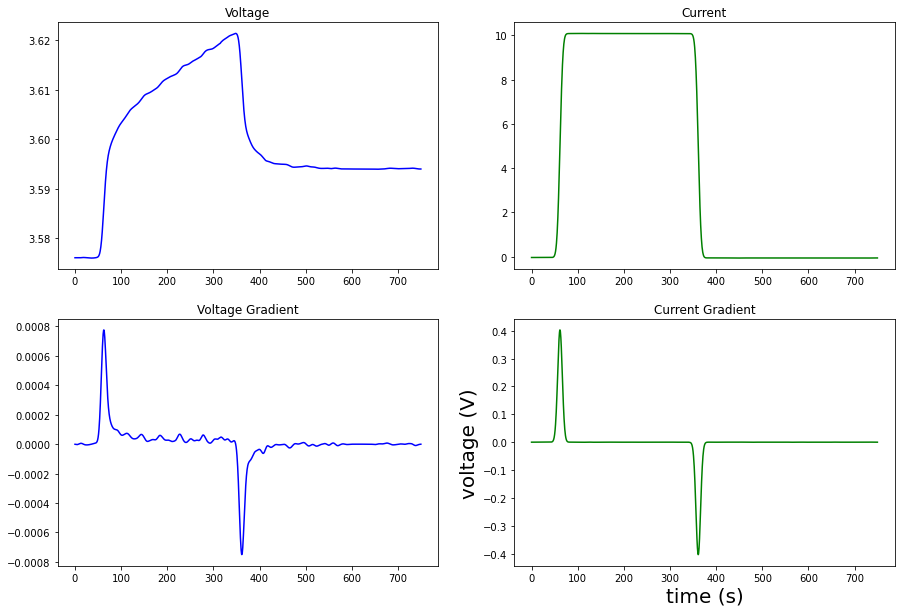

In [3]:
train_current, train_voltage = thevenin.load_profile(TRAIN_PROFILE, HYPER_PARAMETERS, visualize = True)

## Compute Model Parameters

### Step 1: Instantaneuos Voltage Change to deduce $R_0$
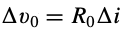

Time of Instantaneuos Voltage Change (s): 361.5
delta_v_0 (V): 0.0178
---------------------------------------------------
Time of Instantaneuos Current Change (s): 361.01
delta_i (A): 10.06843
---------------------------------------------------
R_0 (Ω): 0.001768
---------------------------------------------------
Test: delta_v = r_0 * delta_i = 0.0178


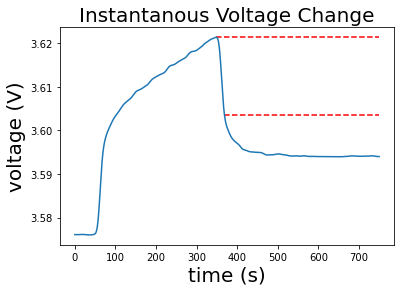

In [4]:
r_0, delta_i, max_volt_change_index = thevenin.identify_instant_volt_change(train_current, train_voltage)

### Step 2: Steady State Voltage Change to deduce $R_1$
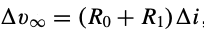

Steady State Time (s): 593.51
---------------------------------------------------
Steady State Voltage (V): 3.594
---------------------------------------------------
delta_v_infty (V): 0.02738
---------------------------------------------------
R_1 (Ω): 0.000952
---------------------------------------------------
Test: delta_v_infty = (R_0 + R_1) * delta_i = 0.02738


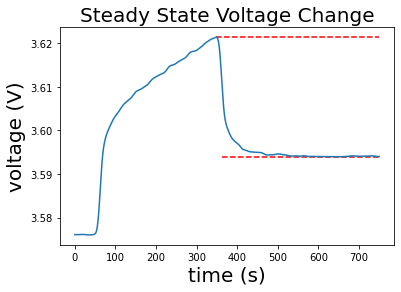

In [5]:
r_1, max_decrease_index, steady_state_time, max_voltage_index, steady_state_index = thevenin.identify_steady_state_voltage_change(train_current, train_voltage, r_0, delta_i, max_volt_change_index, HYPER_PARAMETERS)

### Step 3: Time to decay to Steady State to deduce $C_1$
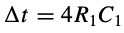

delta_t (s): 232.01
---------------------------------------------------
C_1 (F): 60923.08
---------------------------------------------------
Test: delta_t = 4 * R_1 * C_1 = 232.01
Test: R_1 * C_1 = 58.0025


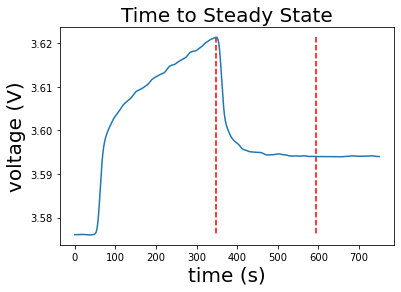

Training Time(s) 0.803


In [6]:
c_1 = thevenin.identify_steady_state_time(train_current, train_voltage, r_1, max_decrease_index, steady_state_time, max_voltage_index, steady_state_index)

t_delta = time.time() - t_0
print('Training Time(s)', round(t_delta, 3))

### Save parameters

In [7]:
parameters = {
    'r_0': r_0,
    'r_1': r_1,
    'c_1': c_1,
}

MODEL_ID = str(np.random.randint(10000))
np.save('../../../models/T/theory_baseline-' + str(MODEL_ID) + '-parameters', parameters)
np.save('../../../models/T/theory_baseline-' + str(MODEL_ID) + '-hyperparameters', HYPER_PARAMETERS)
print('Model saved to /models/T/theory_baseline-' + str(MODEL_ID) +'...')

Model saved to /models/T/theory_baseline-7...


## SOC OCV relationship

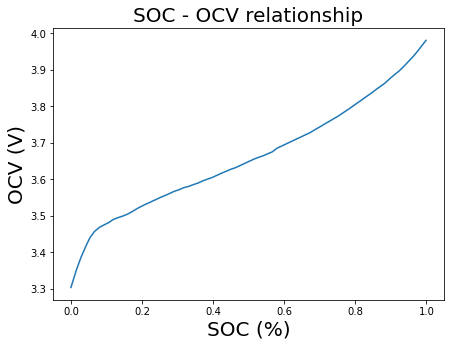

In [8]:
thevenin.plot_SOC_curves('Profile 10A', HYPER_PARAMETERS)

## Voltage Prediction
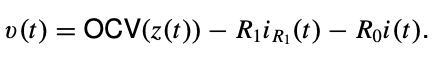

------------------- Params -------------------
v_0 (V): 3.57608
z_t0 (%): 31.4
Q (Ah): 33.2
------------------- Results -------------------


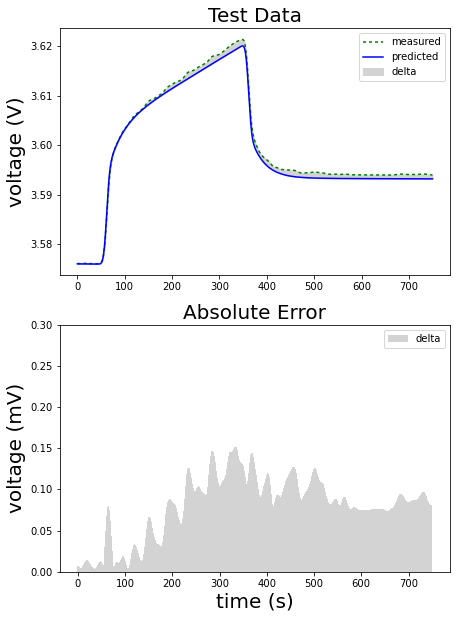

------------------- Evaluation -------------------
MSE(μV): 0.8
Saved plot to: ../../../reports/figures/theory_baseline-7790-Profile 10A-test_profile.png


In [9]:
yhat = thevenin.vis_predict(TRAIN_PROFILE, r_0, r_1, c_1, HYPER_PARAMETERS)

## Test Profile

------------------- Params -------------------
v_0 (V): 3.57608
z_t0 (%): 31.4
Q (Ah): 33.2
------------------- Results -------------------


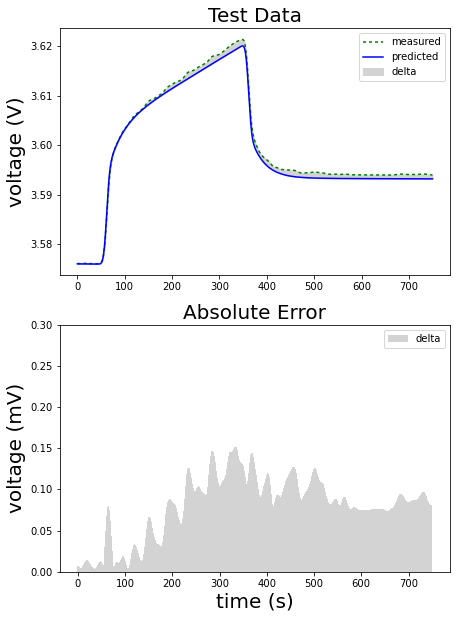

------------------- Evaluation -------------------
MSE(μV): 0.8
Saved plot to: ../../../reports/figures/theory_baseline-5348-Profile 10A-test_profile.png


In [10]:
TEST_PROFILE = 'Profile 10A'
yhat = thevenin.vis_predict(TEST_PROFILE, r_0, r_1, c_1, HYPER_PARAMETERS)

## Test Use Cases

------------------- Params -------------------
v_0 (V): 3.57608
z_t0 (%): 31.4
Q (Ah): 33.2
------------------- Params -------------------
v_0 (V): 3.56624
z_t0 (%): 28.8
Q (Ah): 33.2
------------------- Params -------------------
v_0 (V): 3.54795
z_t0 (%): 24.6
Q (Ah): 33.2
------------------- Params -------------------
v_0 (V): 3.55489
z_t0 (%): 26.3
Q (Ah): 33.2
------------------- Params -------------------
v_0 (V): 3.5487
z_t0 (%): 24.7
Q (Ah): 33.2
------------------- Params -------------------
v_0 (V): 3.54576
z_t0 (%): 24.1
Q (Ah): 33.2
------------------- Params -------------------
v_0 (V): 3.55807
z_t0 (%): 27.0
Q (Ah): 33.2
------------------- Params -------------------
v_0 (V): 3.55309
z_t0 (%): 25.8
Q (Ah): 33.2
##############################################################
            Use Case 1    Use Case 2    Use Case 3
--------  ------------  ------------  ------------
MSE (μV)       34.8          15.1          25.7
MAE (V)         0.0043        0.0033        0.0041
M

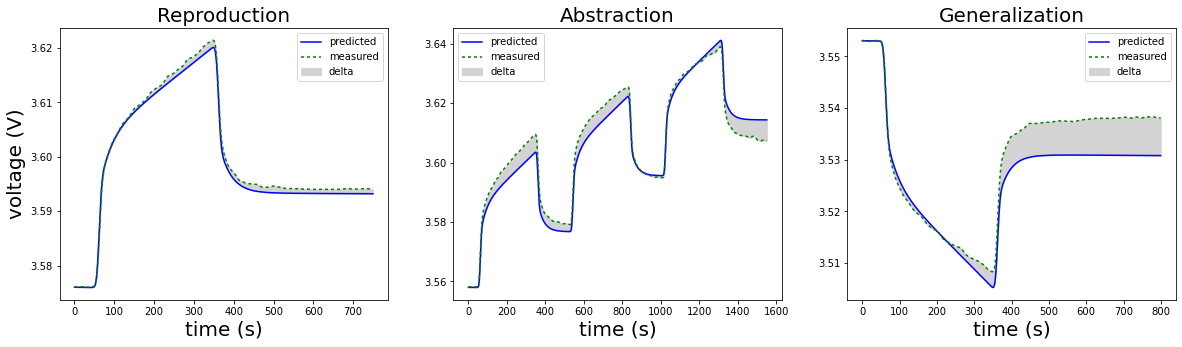

Saved plot to: ../../../reports/figures/theory_baseline-4776-Profile -10A-test_profile.png


In [11]:
TEST_PROFILES = ['Profile 10A',
                'Profile 10A Run 040618',
                'Profile 10A Run 080618', 
                'Profile 10A Run 070618_3',
                'Profile 10A Run 070618',
                'Profile 10A Run 070618_2']

profiles = TEST_PROFILES + ['Profile 10A 3x', 'Profile -10A']
yhat = thevenin.vis_predict_usecases(profiles, r_0, r_1, c_1, HYPER_PARAMETERS)

## Create Bigger Profiles

3000


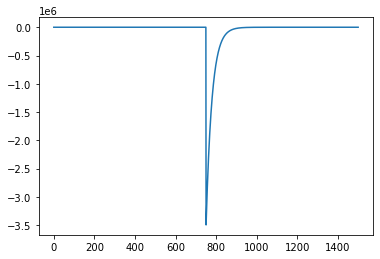

In [33]:
import src.data.data_preprocessing as util

test_current, test_voltage = thevenin.load_profile('Profile 10A', HYPER_PARAMETERS, cutoff_time = 700)

test_voltage_time = test_voltage[:,0]
test_voltage_profile = test_voltage[:,1]

test_current_time = test_current[:,0]
test_current_time = np.append(test_current_time, test_current_time)

test_current_profile = test_current[:,1]
test_current_profile = np.append(test_current_profile, test_current_profile)
# plt.plot(test_current_profile)
print(test_current_profile.shape[0])

z_1, v_1, z_2, v_2, ocv_curve_exact_lin = thevenin.get_SOC_values('Profile 10A', HYPER_PARAMETERS)

# ------------- set parameters -------------
v_0 = test_voltage_profile[0]
z_t0 = thevenin.ocv_inverse_exact_lin(v_0, ocv_curve_exact_lin)
q = 33.2 # expert knowledge

# ------------- predict profile -------------
v_class = thevenin.v_wrapper(z_t0, q, r_0, r_1, c_1)
vhat_profile = list()

for i in range(test_current_profile.shape[0]):
    if (i == 0):
        d_t = 0.25 * HYPER_PARAMETERS['d_sample']
    else:
        d_t = test_current_time[i] - test_current_time[i-1]

    i_k = - test_current_profile[i] # i_k is negative on charge and positive on discharge
    vhat = v_class.v_k(i_k, d_t * 2, z_1, v_1, z_2, v_2, ocv_curve_exact_lin)
    vhat_profile.append(vhat)

vhat_profile = np.array(vhat_profile)    
v = util.align(vhat_profile, test_voltage_profile)

plt.plot(v)